## Q1 - Research Question

As cities expand, urban sprawl often leads to the unchecked conversion of natural landscapes into low-density, built-up areas, resulting in a significant loss of green space. Greenspaces, such as parks and urban forests, are vital for maintaining biodiversity, enhancing residents’ well-being, and mitigating urban heat effects. However, without thoughtful planning, sprawl can fragment ecosystems and reduce access to nature. Urban zoning policies play a crucial role in balancing development and conservation by setting limits on where and how growth occurs. Zoning rules that require or prioritize greenspace preservation can help ensure that expanding cities retain critical natural areas, even amid rapid urban growth. For our project, we wanted to explore the role of zoning regulations in shaping greenspace patterns in cities facing urban sprawl.

In this study, we examined the effects of three different zoning regulation approaches on greenspace patterns in cities experiencing urban sprawl.
- **Scenario 1: increased regulation** - Zoning laws restrict, rather than prohibit, further urbanization in heavily urbanized neighborhoods, making additional urbanization less likely. This could involve higher permit costs or more stringent approval processes, such as stricter environmental impact assessments.
- **Scenario 2: strict caps** - Zoning laws entirely ban additional urbanization in neighborhoods that have surpassed a certain threshold of urbanization.
- **Scenario 3: strict caps with rnadom growth** - Similar to Scenario 2, but allows for random urbanization around the city’s core, though at a low probability.

To evaluate how each scenario affects greenspace, we compared their performance across several key measures. Greenspace in cities can be quantified in various ways, but typical metrics focus on how much greenspace exists and how evenly it is distributed, as both are crucial for ensuring residents’ access to nature. We used four metrics to assess the final greenspace patterns under each scenario:
1. **Greenspace share** - the percent of the city covered by greenspace.
2. **Access to greenspace** - the percent of the urban area which directly neighbors a greenspace.
3. **Size of the largest greenspace** - the area of the largest greenspace.
4. **Size of the average greenspace** - the average area of all of the greenspaces in the city.As cities expand, urban sprawl often leads to the unchecked conversion of natural landscapes into low-density, built-up areas, resulting in a significant loss of green space. Greenspaces, such as parks and urban forests, are vital for maintaining biodiversity, enhancing residents’ well-being, and mitigating urban heat effects. However, without thoughtful planning, sprawl can fragment ecosystems and reduce access to nature. Urban zoning policies play a crucial role in balancing development and conservation by setting limits on where and how growth occurs. Zoning rules that require or prioritize greenspace preservation can help ensure that expanding cities retain critical natural areas, even amid rapid urban growth. For our project, we wanted to explore the role of zoning regulations in shaping greenspace patterns in cities facing urban sprawl.

In this study, we examined the effects of three different zoning regulation approaches on greenspace patterns in cities experiencing urban sprawl.
- **Scenario 1: increased regulation** - Zoning laws restrict, rather than prohibit, further urbanization in heavily urbanized neighborhoods, making additional urbanization less likely. This could involve higher permit costs or more stringent approval processes, such as stricter environmental impact assessments.
- **Scenario 2: strict caps** - Zoning laws entirely ban additional urbanization in neighborhoods that have surpassed a certain threshold of urbanization.
- **Scenario 3: strict caps with rnadom growth** - Similar to Scenario 2, but allows for random urbanization around the city’s core, though at a low probability.

To evaluate how each scenario affects greenspace, we compared their performance across several key measures. Greenspace in cities can be quantified in various ways, but typical metrics focus on how much greenspace exists and how evenly it is distributed, as both are crucial for ensuring residents’ access to nature. We used four metrics to assess the final greenspace patterns under each scenario:
1. **Greenspace share** - the percent of the city covered by greenspace.
2. **Access to greenspace** - the percent of the urban area which directly neighbors a greenspace.
3. **Size of the largest greenspace** - the area of the largest greenspace.
4. **Size of the average greenspace** - the average area of all of the greenspaces in the city.

## Q2 - Model Description




**Overview**

To simulate how zoning regulations impact urban sprawl and greenspace patterns, we built a cellular automaton model. The model represents an expanding city and the transformation of nature into urban areas over time. We simulate this process by defining states for cells, setting initial conditions, and establishing rules for how urbanization occurs. Zoning laws are modeled as chnages to those rulesets based on how the zoning scenario is defined. Below, we break down the key elements of the model, followed by the model code.

**States and Grid Setup**

The model operates on a two-state system:

- Nature (green, 0): Cells in a natural state.
- Urban (white, 1): Cells that have been urbanized.

The grid represents the 'world' where a city develops over time. Initially, only one urban cell exists at the center of the grid, surrounded by nature cells. This configuration mimics the early stage of urbanization, with nature dominating the landscape. Our code can be adjusted to run for any size world, but our runs are based on a 51x51 grid.

**Boundary Conditions**

Cells outside the grid are assumed to be nature, providing a “buffer” of natural land around the city as it grows. This allows us to simulate urban sprawl without arbitrary edge effects.

**Timesteps and Saturation Condition**

The simulation progresses in discrete timesteps. To determine when the city has “finished” urbanizing, we focus on the point when urbanization stabilizes in the core area of our world. While the city could continue to grow beyond the boundaries of our world, we are primarily interested in how the urban core develops and expands until it reaches a stable state within the grid area.

This stable point is defined by a saturation threshold, controlled by a parameter T. Saturation occurs when T consecutive updates pass without any new urbanization. T is a tunable parameter in our model. For the simulations presented, T = 10, meaning that if no cells urbanize for 10 consecutive timesteps, the city is considered fully saturated and the simulation ends.

**Update Rules**

At each timestep, the states of all cells update synchronously based on the following rules:

- Urban cells: Once a cell becomes urban, it remains urban permanently.
- Nature cells: Nature cells urbanize stochastically, with the probability of urbanization ($P_N$) determined by the number of neighboring urban cells in the previous timestep. For our simulation, we use a 5x5 extended Moore neighborhood, meaning that the probability that a cell urbanizes is affected by how many urban neighbors are within 2 steps (proximity) away from that cell.

The probability that a nature cell urbanizes ($P_N$) is based on how many urban cells surround it. Without zoning regulations, these probabilities follow a gradient:

- P₀: Probability of urbanization with no urban neighbors.
- P₁: Probability of urbanization with one urban neighbor.
- P₂: Probability of urbanization with two urban neighbors.
- And so on, until P_MAX, the maximum probability.

Our model allows users to set the $P_N$ values using sliders. Zoning laws are introduced by adjusting $P_N$ to represent different levels of regulation. Different combinations of values for $P_N$ simulate varying degrees of restriction or allowance of urbanization. The specific rulesets used for each scenario are shown in the results in Question 4.

## Q3 - Model code

## Q4 

To answer our research question using the cellular automaton model, we defined three rulesets for the probabilities $P_N$ corresponding to the three zoning scenarios. We then compared the outcomes across the four key metrics of greenspace. Given the stochastic nature of urbanization in the model, we ran 100 simulations for each scenario and averaged the results to make comparisons more reliable. Each ruleset and its outcomes are discussed in turn, followed by a comparison of the scenarios.

**Scenario 1: Increased regulation**

In this scenario, zoning laws aim to restrict, rather than prohibit, further urbanization in already heavily urbanized areas by reducing the likelihood of additional development. We model this by decreasing the probability of urbanization for cells with more than seven urban neighbors. The exact set of ruleset of $P_N$'s used for this scenario is shown in Figure 1 below.

Figure 1 also includes a sample run of the simulation for Scenario 1, along with histograms of the four greenspace metrics from all 100 simulations. The results show that increased regulation preserves, on average, 35% of the city as greenspace, with 83% of urban cells having direct access to greenspace (i.e. being directly adjacent to a greenspace cell). The average greenspace size is 2.8 cells, while the largest greenspace averages 17 cells. However, this distribution is skewed, with some simulations producing a largest greenspace of up to 30 cells.

*Fig. 1: Scenario 1 ruleset, sample run, and results*

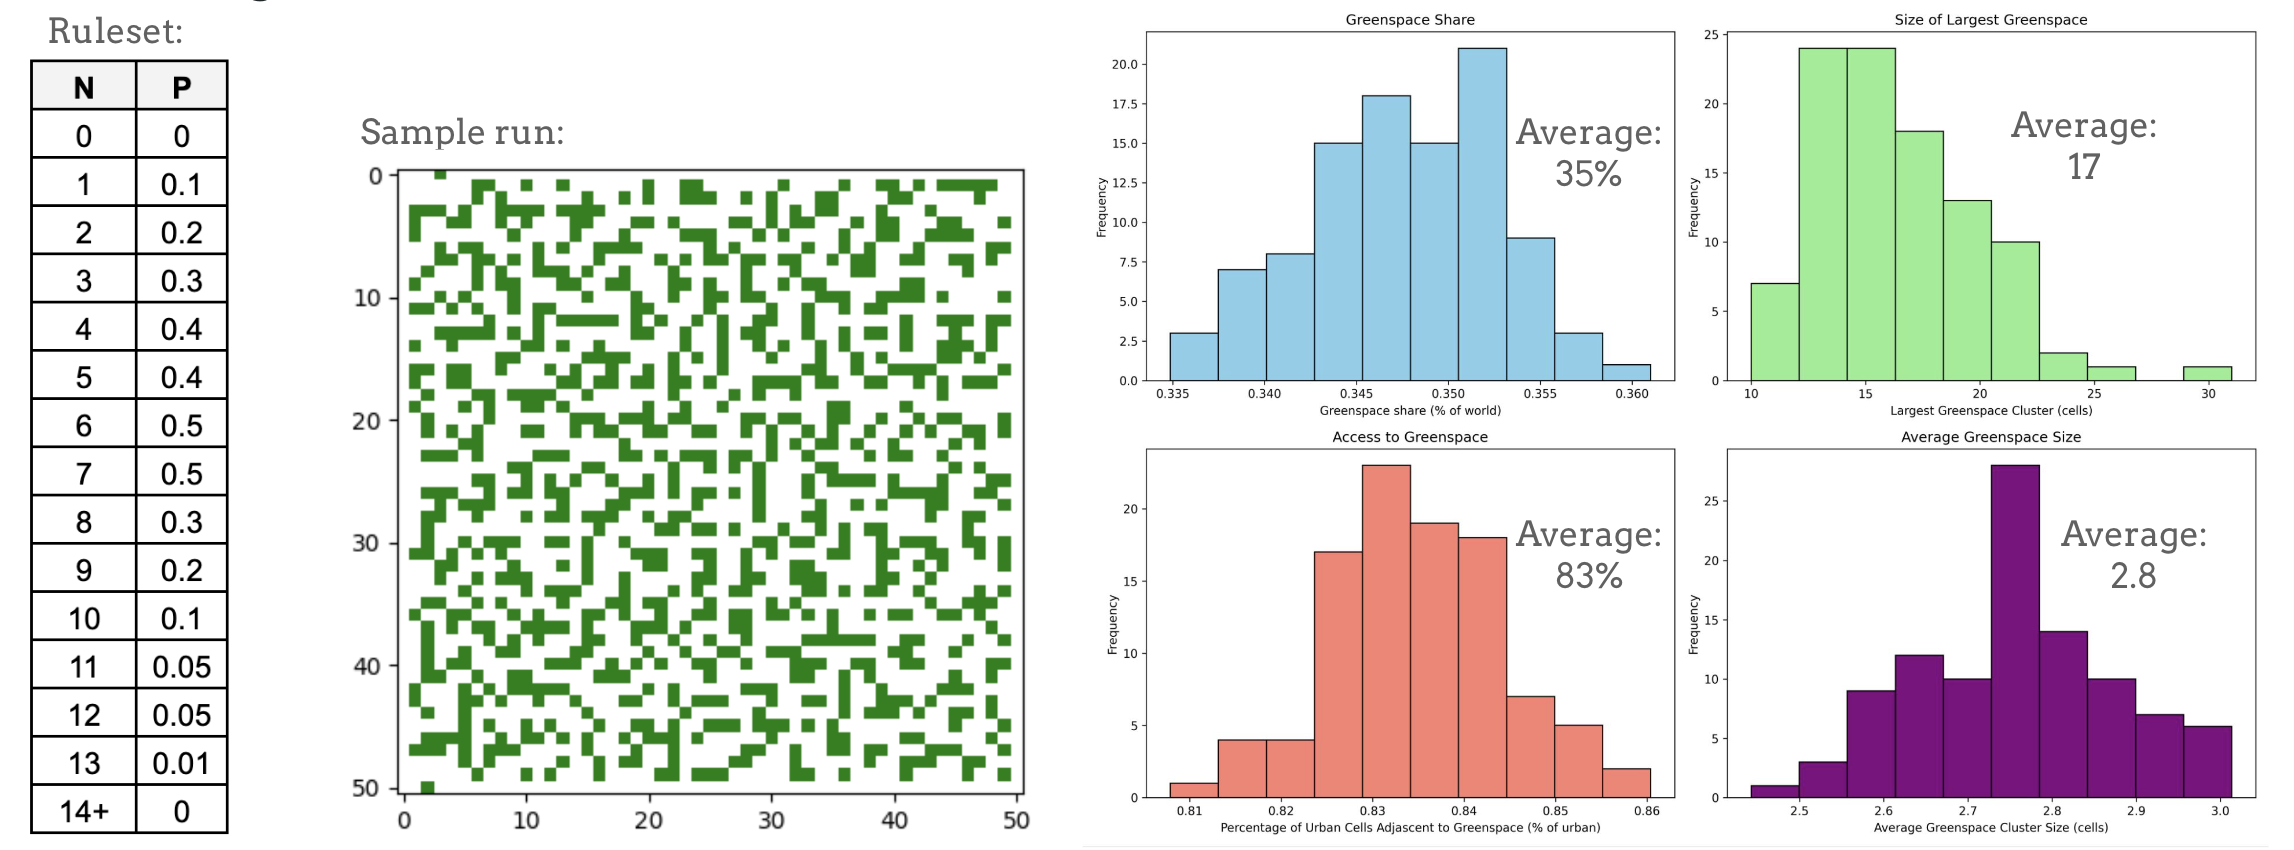

**Scenario 2: Strict caps**

In this scenario, zoning laws prohibit further urbanization in already heavily urbanized areas. We model this by setting the probability of urbanization for cells with more than nine urban neighbors as 0. The exact set of ruleset of $P_N$'s used for this scenario is shown in Figure 2 below.

Figure 2 also includes a sample run of the simulation for Scenario 2, along with histograms of the four greenspace metrics from all 100 simulations. The results show that increased regulation preserves, on average, 39% of the city as greenspace, with 88% of urban cells having direct access to greenspace (i.e. being directly adjacent to a greenspace cell). The average greenspace size is 3.2 cells, while the largest greenspace averages 24 cells. Both the distribution of largest greenspace and average greenspace size are skewed, with some simulations producing a largest greenspace of 45 cells.

*Fig. 2: Scenario 2 ruleset, sample run, and results*

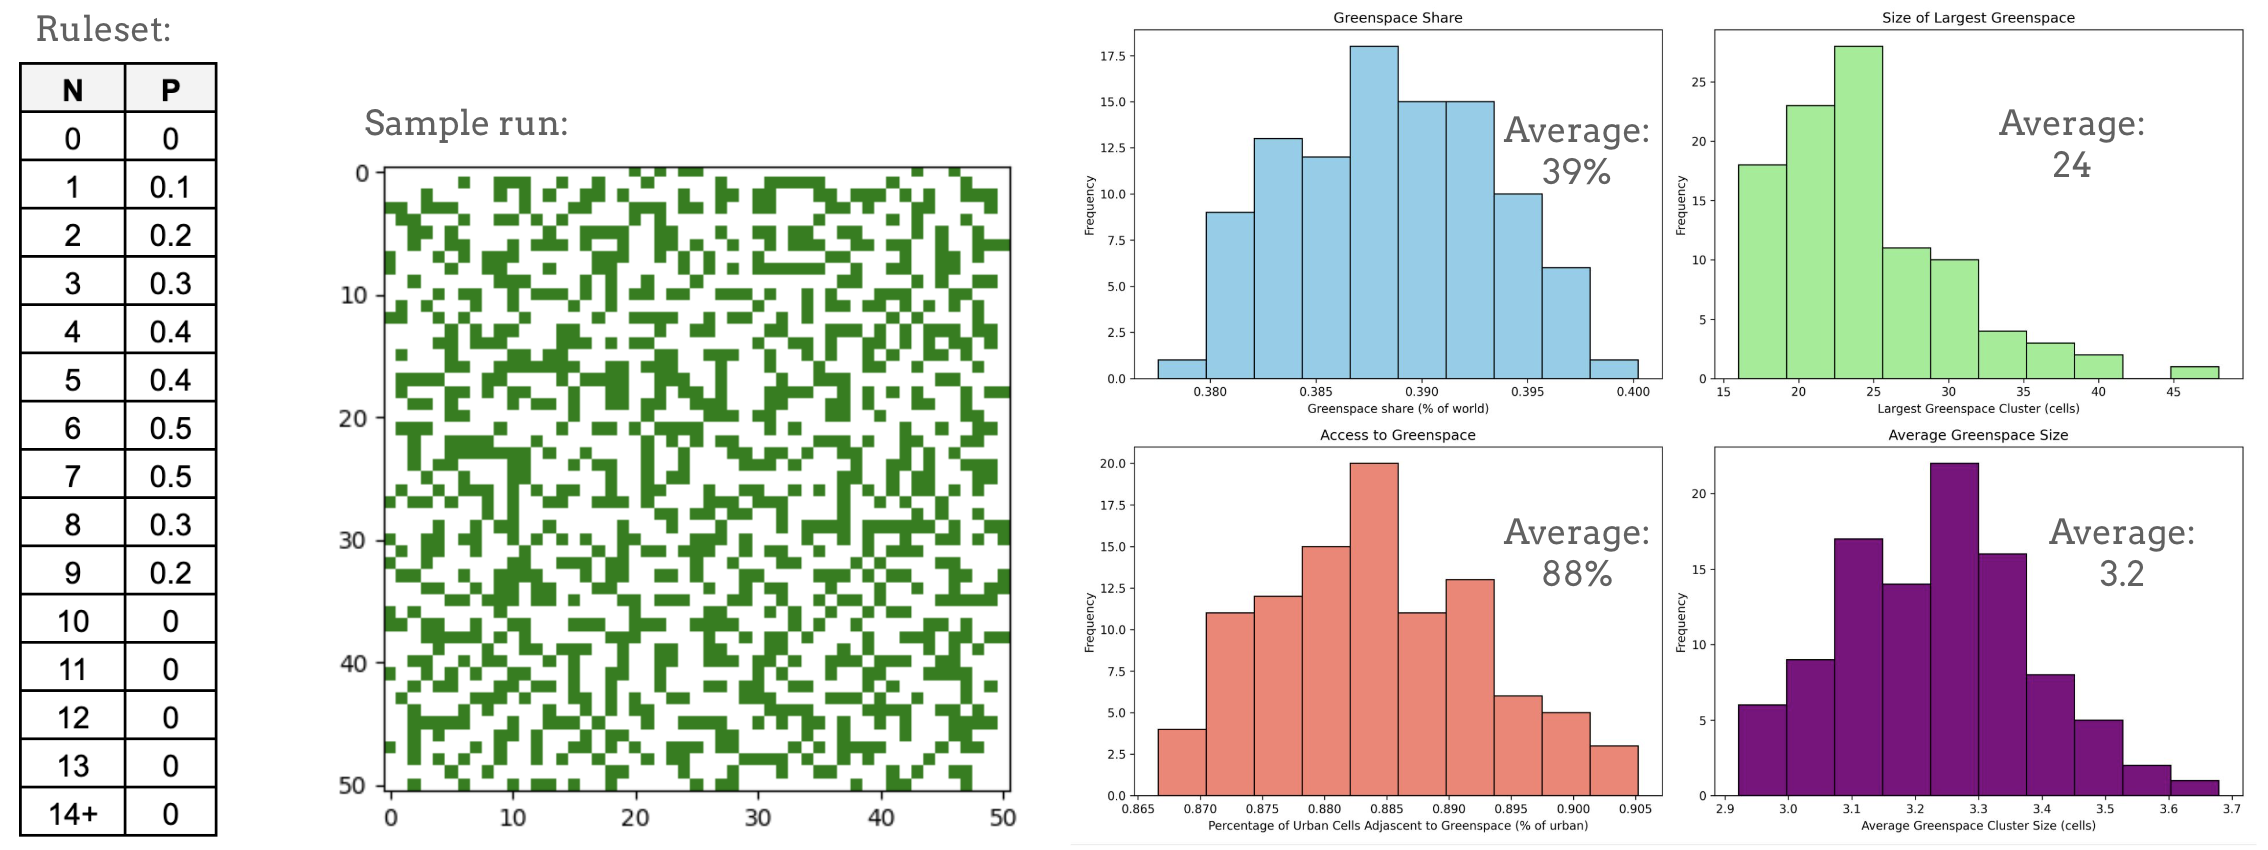


**Scenario 3: Strict caps with random growth**

In this scenario, the same zoning laws from Scenario 2 are used, but urbanization can also occur randomly outside of the urban core. We model this by increasing the probability of urbanization for cells with zero urban neighbors from 0 to 0.05. The exact set of ruleset of  $𝑃_𝑁$ 's used for this scenario is shown in Figure 3 below.

Figure 3 also includes a sample run of the simulation for Scenario 3, along with histograms of the four greenspace metrics from all 100 simulations. The results show that increased regulation preserves, on average, 43% of the city as greenspace, with 89% of urban cells having direct access to greenspace (i.e. being directly adjacent to a greenspace cell). The average greenspace size is 4.6 cells, while the largest greenspace averages 48 cells. Both the distribution of largest greenspace and average greenspace size are skewed, with some simulations producing a largest greenspace of more than 100 cells.

*Fig. 3: Scenario 3 ruleset, sample run, and results*

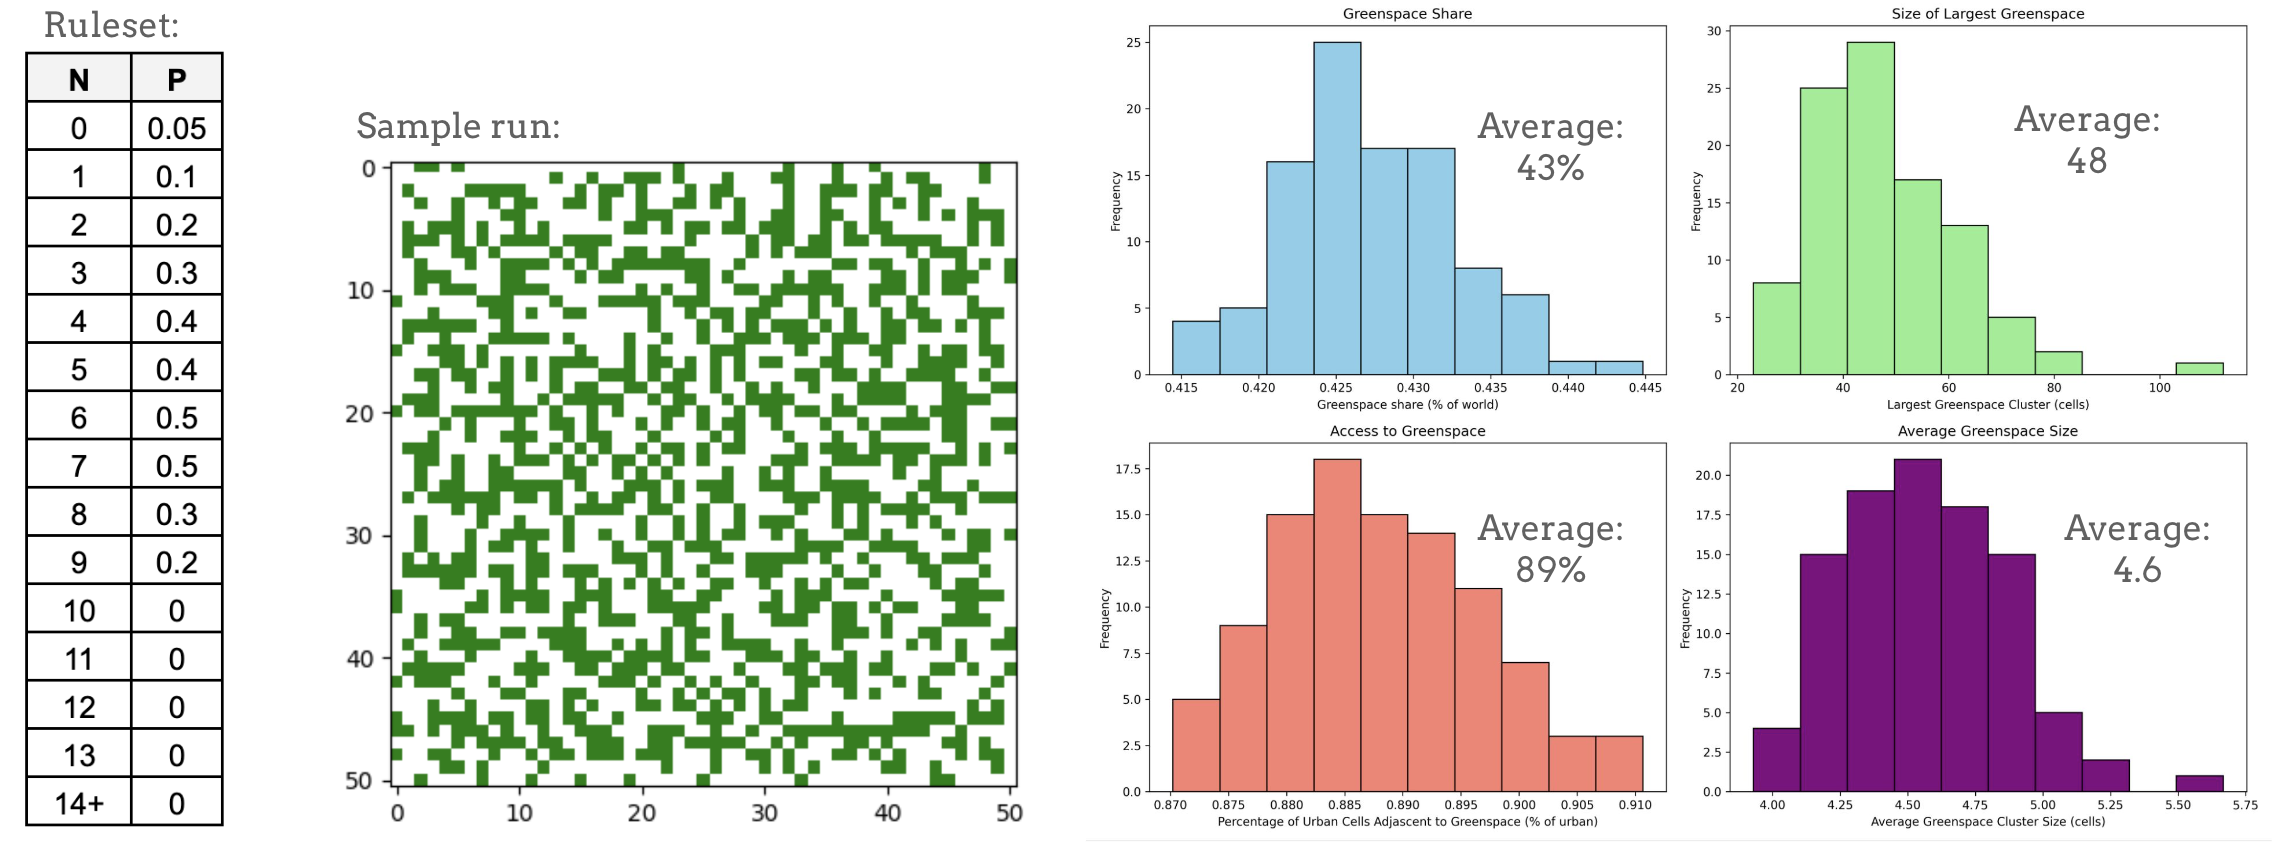

**Comparing scenarios**

We compare the performance of the three zoning scenarios across the four metrics of greenspace, as illustrated in Figure 4. The results reveal three key findings.

First, hard zoning caps consistently outperform increased regulation across all four metrics of greenspace (Scenario 1 vs Scenario 2)- not only preserving a greater share of greenspace but also resulting in increased overall access to greenspace.

Second, hard zoning caps demonstrate improved performance across all four greenspace metrics when random, non-contiguous urbanization is allowed (Scenario 2 vs. Scenario 3). Notably, the size of the largest greenspace is, on average, nearly double when random growth is permitted. This can be attributed to the emergence of multiple urban clusters during random urbanization. When these clusters eventually converge, they effectively trap more greenspace in a natural state compared to scenarios where urbanization fills in the gaps as the city expands.

Finally, despite the positive impacts of all zoning scenarios on greenspace, the average greenspace size remains relatively small across the board. This finding suggests that maintaining large, uninterrupted greenspaces may require additional planning interventions beyond those considered in this project.

*Fig. 4: Greenspace performance across all 3 scenarios*

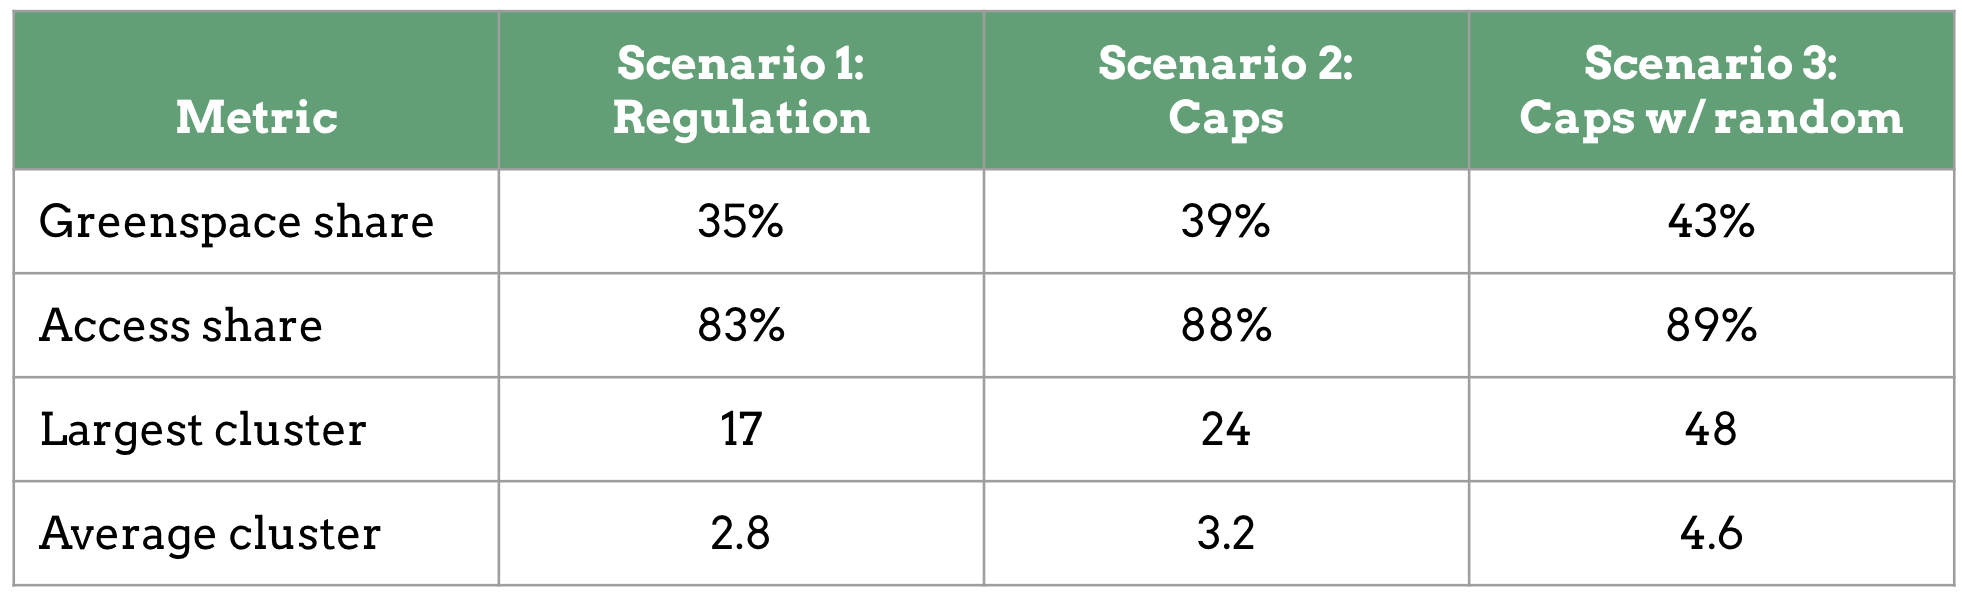

## Q5 - presentation 

[Link to Youtube presentation](https://youtu.be/V_8uXu-1aU4)

## Q6

Below is the code for our implimentation of Diffusion-Limited Aggregation. 

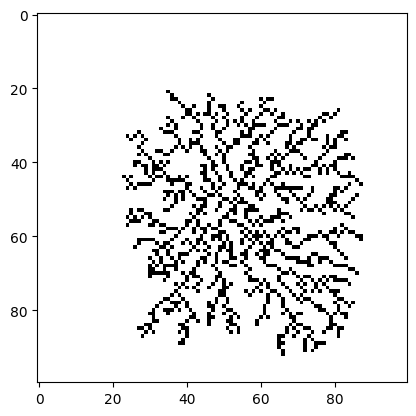

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from IPython import display
import time

rng = np.random.default_rng()

# use display.display to show every step of progress. Gets slow fast
animate_progress = False # @param {type:"boolean"}
# save animation after the fact, faster than live animation but takes a bit to process
save_animation = False # @param {type:"boolean"}

# Length of one side of the grid
S = 100 # @param {type:"slider", min:5, max:200, step:1}
center = (S//2,S//2)

# World grid
world = []

# aggregate size to stop at
T = 1000 # @param {type:"slider", min:10, max:1000, step:1}

# Number of active walkers to maintain
W = 50 # @param {type:"slider", min:1, max:100, step:1}

# Bias walker movement towards the center
use_gravity = True # @param {type:"boolean"}

# Strength of gravity bias
gravity_strength = 1 # @param {type:"slider", min:0.0, max:1.0, step:0.1}

# Collection of active walkers
walkers = []

# Collection of cells currently in the aggregate
aggregate = []

# Chance for a walker to go up+left, up, up+right, left, right, down+left, down, down+right, respectively
chances = [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
# chances = [.25, 0, .25, 0, 0, .25, 0, .25]
summed_chances = [np.sum(chances[0:1:1]), np.sum(chances[0:2:1]),
                  np.sum(chances[0:3:1]), np.sum(chances[0:4:1]),
                  np.sum(chances[0:5:1]), np.sum(chances[0:6:1]),
                  np.sum(chances[0:7:1]), np.sum(chances[0:8:1])]

# displays the current state of world cells
def display_world():
    plt.imshow(world, cmap=plt.get_cmap(cm.Greys))
    display.display(plt.gcf())
    display.clear_output(wait=True)

def get_edge_spot():
    # uncomment to spawn new walkers anywhere rather than only at edges
    # return(rng.integers(S),rng.integers(S))
    edge_offset = rng.integers(1)
    roll = rng.random()
    if roll < 0.25:
        return (edge_offset,rng.integers(S))
    if roll < 0.5:
        return (S-1-edge_offset,rng.integers(S))
    if roll < 0.75:
        return (rng.integers(S),edge_offset)
    else:
        return (rng.integers(S),S-1-edge_offset)

def spawn_new_walker():
    spawn = get_edge_spot()
    while world[spawn] != 0 or is_aggregate_adjacent(spawn):
        spawn = get_edge_spot()
    world[spawn] = 1
    walkers.append(spawn)

def is_aggregate_adjacent(cell):
    i = cell[0]
    j = cell[1]
    if world[(i+1)%S][j] == 2:
        return True
    if world[(i+1)%S][(j+1)%S] == 2:
        return True
    if world[(i+1)%S][(j-1)%S] == 2:
        return True
    if world[i][(j+1)%S] == 2:
        return True
    if world[i][(j-1)%S] == 2:
        return True
    if world[(i-1)%S][j] == 2:
        return True
    if world[(i-1)%S][(j+1)%S] == 2:
        return True
    if world[(i-1)%S][(j-1)%S] == 2:
        return True

def biased_direction(walker, target):
    # Compute squared Euclidean distance to the center (where the first aggregate formed)
    walker_dist = (walker[0] - center[0])**2 + (walker[1] - center[1])**2
    target_dist = (target[0] - center[0])**2 + (target[1] - center[1])**2
    bias = max(0, walker_dist - target_dist) / walker_dist if walker_dist > 0 else 0
    return bias * gravity_strength  # Scale the bias by gravity_strength

def update_walker_with_gravity(walker):
    # check if aggregate formed next to walker since last update
    if is_aggregate_adjacent(walker):
        world[walker] = 2
        walkers.remove(walker)
        aggregate.append(walker)
        return

    moved = False
    while not moved:
        roll = rng.random()
        # Calculate bias for each direction
        biases = [
            biased_direction(walker, ((walker[0]+1)%S, (walker[1]-1)%S)),   # up/left
            biased_direction(walker, ((walker[0]+1)%S, walker[1])),         # up
            biased_direction(walker, ((walker[0]+1)%S, (walker[1]+1)%S)),   # up/right
            biased_direction(walker, (walker[0], (walker[1]-1)%S)),         # left
            biased_direction(walker, (walker[0], (walker[1]+1)%S)),         # right
            biased_direction(walker, ((walker[0]-1)%S, (walker[1]-1)%S)),   # down/left
            biased_direction(walker, ((walker[0]-1)%S, walker[1])),         # down
            biased_direction(walker, ((walker[0]-1)%S, (walker[1]+1)%S))    # down/right
        ]

        # Normalize biases
        total_bias = sum(biases)
        probabilities = [0.125 + (b / total_bias if total_bias > 0 else 0) for b in biases]

        # Normalize probabilities so they sum to 1
        # rounding errors sometimes leave these summing to 1 +/- 2e-16, having a negligible effect
        normalization_factor = np.sum(probabilities)
        probabilities = [p / normalization_factor for p in probabilities]

        # Move based on probabilities
        if roll < probabilities[0]:                     # move up/left
            target = ((walker[0]+1)%S, (walker[1]-1)%S)
        elif roll < np.sum(probabilities[0:2:1]):       # move up
            target = ((walker[0]+1)%S, walker[1])
        elif roll < np.sum(probabilities[0:3:1]):       # move up/right
            target = ((walker[0]+1)%S, (walker[1]+1)%S)
        elif roll < np.sum(probabilities[0:4:1]):       # move left
            target = (walker[0], (walker[1]-1)%S)
        elif roll < np.sum(probabilities[0:5:1]):       # move right
            target = (walker[0], (walker[1]+1)%S)
        elif roll < np.sum(probabilities[0:6:1]):       # move down/left
            target = ((walker[0]-1)%S, (walker[1]-1)%S)
        elif roll < np.sum(probabilities[0:7:1]):       # move down
            target = ((walker[0]-1)%S, walker[1])
        else:                                           # move down/right
            target = ((walker[0]-1)%S, (walker[1]+1)%S)

        if world[target] == 0:
            if is_aggregate_adjacent(target):
                world[walker] = 0
                walkers.remove(walker)
                world[target] = 2
                aggregate.append(target)
            else:
                world[walker] = 0
                world[target] = 1
                walkers[walkers.index(walker)] = target
            moved = True

def update_walker(walker):
    # check if aggregate formed next to walker since last update
    if is_aggregate_adjacent(walker):
        world[walker] = 2
        walkers.remove(walker)
        aggregate.append(walker)
        return

    moved = False
    while not moved:
        roll = rng.random()
        i = walker[0]
        j = walker[1]
        if roll < summed_chances[0]: # move up/left
            target = ((i+1)%S,(j-1)%S)
        elif roll < summed_chances[1]: # move up
            target = ((i+1)%S,j)
        elif roll < summed_chances[2]: # move up/right
            target = ((i+1)%S,(j+1)%S)
        elif roll < summed_chances[3]: # move left
            target = (i,(j-1)%S)
        elif roll < summed_chances[4]: # move right
            target = (i,(j+1)%S)
        elif roll < summed_chances[5]: # move down/left
            target = ((i-1)%S, (j-1)%S)
        elif roll < summed_chances[6]: # move down
            target = ((i-1)%S, j)
        else: # move down/right
            target = ((i-1)%S, (j+1)%S)
        
        if world[target[0]][target[1]] == 0:
            if is_aggregate_adjacent(target):
                world[walker] = 0
                walkers.remove(walker)
                world[target] = 2
                aggregate.append(target)
            else:
                world[walker] = 0
                world[target] = 1
                walkers[walkers.index(walker)] = target
            moved = True

# set up initial world
world = np.zeros((S,S))
world[center] = 2
aggregate.append(center)

# set up initial walkers
for n in range(W):
    spawn_new_walker()

if save_animation:
    img = [] # frame images
    fig = plt.figure()

running = True
while len(aggregate) < T:
    if animate_progress:
        display_world()
    for walker in walkers:
        if use_gravity:
            update_walker_with_gravity(walker)
        else:
            update_walker(walker)
    while len(walkers) < W:
        spawn_new_walker()
    if save_animation:
        img.append([plt.imshow(world, cmap=plt.get_cmap(cm.Greys))])

# clear walkers from grid
for walker in walkers:
    world[walker] = 0

if save_animation:
    ani = animation.ArtistAnimation(fig=fig, artists=img, interval=100)
    timestamp = time.strftime("%m-%d-%H-%M-%S", time.localtime())
    ani.save(f'animations/{timestamp}-movie.gif', writer="pillow")

display_world()

## Q7 & Q8

Below is the code for our implimentation of a gravity speed up in our DLA, including producing a figure.  

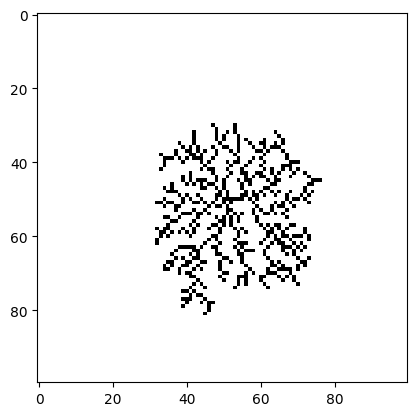

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from IPython import display
import time

rng = np.random.default_rng()

# use display.display to show every step of progress. Gets slow fast
animate_progress = False # @param {type:"boolean"}
# save animation after the fact, faster than live animation but takes a bit to process
save_animation = False # @param {type:"boolean"}

# Length of one side of the grid
S = 100 # @param {type:"slider", min:5, max:200, step:1}

# World grid
world = []

# aggregate size to stop at
T = 500 # @param {type:"slider", min:10, max:1000, step:1}

# Number of active walkers to maintain
W = 50 # @param {type:"slider", min:1, max:100, step:1}

# Strength of gravity bias
gravity_strength = 1 # @param {type:"slider", min:0.0, max:1.0, step:0.1}

# Collection of active walkers
walkers = []

# Collection of cells currently in the aggregate
aggregate = []

# displays the current state of world cells
def display_world():
    plt.imshow(world, cmap=plt.get_cmap(cm.Greys))
    display.display(plt.gcf())
    display.clear_output(wait=True)

def get_edge_spot():
    # uncomment to spawn new walkers anywhere rather than only at edges
    # return(rng.integers(S),rng.integers(S))
    edge_offset = rng.integers(1)
    roll = rng.random()
    if roll < 0.25:
        return (edge_offset,rng.integers(S))
    if roll < 0.5:
        return (S-1-edge_offset,rng.integers(S))
    if roll < 0.75:
        return (rng.integers(S),edge_offset)
    else:
        return (rng.integers(S),S-1-edge_offset)

def spawn_new_walker():
    spawn = get_edge_spot()
    while world[spawn[0]][spawn[1]] != 0 or is_aggregate_adjacent(spawn):
        spawn = get_edge_spot()
    world[spawn[0]][spawn[1]] = 1
    walkers.append(spawn)

def is_aggregate_adjacent(cell):
    i = cell[0]
    j = cell[1]
    if world[(i+1)%S][j] == 2:
        return True
    if world[(i+1)%S][(j+1)%S] == 2:
        return True
    if world[(i+1)%S][(j-1)%S] == 2:
        return True
    if world[i][(j+1)%S] == 2:
        return True
    if world[i][(j-1)%S] == 2:
        return True
    if world[(i-1)%S][j] == 2:
        return True
    if world[(i-1)%S][(j+1)%S] == 2:
        return True
    if world[(i-1)%S][(j-1)%S] == 2:
        return True

def biased_direction(walker, target):
    # Compute Euclidean distance to the center (where the first aggregate formed)
    center = (S//2, S//2)
    walker_dist = np.sqrt((walker[0] - center[0])**2 + (walker[1] - center[1])**2)
    target_dist = np.sqrt((target[0] - center[0])**2 + (target[1] - center[1])**2)
    bias = max(0, walker_dist - target_dist) / walker_dist if walker_dist > 0 else 0
    return bias * gravity_strength  # Scale the bias by gravity_strength

def update_walker(walker):
    moved = False
    while not moved:
        roll = rng.random()

        # Calculate bias for each direction
        biases = [
            biased_direction(walker, ((walker[0]+1)%S, (walker[1]-1)%S)),  # up/left
            biased_direction(walker, ((walker[0]+1)%S, walker[1])),      # up
            biased_direction(walker, ((walker[0]+1)%S, (walker[1]+1)%S)), # up/right
            biased_direction(walker, (walker[0], (walker[1]-1)%S)),      # left
            biased_direction(walker, (walker[0], (walker[1]+1)%S)),      # right
            biased_direction(walker, ((walker[0]-1)%S, (walker[1]-1)%S)), # down/left
            biased_direction(walker, ((walker[0]-1)%S, walker[1])),      # down
            biased_direction(walker, ((walker[0]-1)%S, (walker[1]+1)%S)) # down/right
        ]

        # Normalize biases
        total_bias = sum(biases)
        probabilities = [0.125 + (b / total_bias if total_bias > 0 else 0) for b in biases]

        # Normalize probabilities so they sum to 1
        normalization_factor = sum(probabilities)
        probabilities = [p / normalization_factor for p in probabilities]

        # Move based on probabilities
        if roll < probabilities[0]:  # move up/left
            target = ((walker[0]+1)%S, (walker[1]-1)%S)
        elif roll < probabilities[0] + probabilities[1]:  # move up
            target = ((walker[0]+1)%S, walker[1])
        elif roll < probabilities[0] + probabilities[1] + probabilities[2]:  # move up/right
            target = ((walker[0]+1)%S, (walker[1]+1)%S)
        elif roll < probabilities[0] + probabilities[1] + probabilities[2] + probabilities[3]:  # move left
            target = (walker[0], (walker[1]-1)%S)
        elif roll < probabilities[0] + probabilities[1] + probabilities[2] + probabilities[3] + probabilities[4]:  # move right
            target = (walker[0], (walker[1]+1)%S)
        elif roll < probabilities[0] + probabilities[1] + probabilities[2] + probabilities[3] + probabilities[4] + probabilities[5]:  # move down/left
            target = ((walker[0]-1)%S, (walker[1]-1)%S)
        elif roll < probabilities[0] + probabilities[1] + probabilities[2] + probabilities[3] + probabilities[4] + probabilities[5] + probabilities[6]:  # move down
            target = ((walker[0]-1)%S, walker[1])
        else:  # move down/right
            target = ((walker[0]-1)%S, (walker[1]+1)%S)

        if world[target[0]][target[1]] == 0:
            if is_aggregate_adjacent(target):
                world[walker[0]][walker[1]] = 0
                walkers.remove(walker)
                world[target[0]][target[1]] = 2
                aggregate.append(target)
            else:
                world[walker[0]][walker[1]] = 0
                world[target[0]][target[1]] = 1
                walkers[walkers.index(walker)] = target
            moved = True

# set up initial world
world = np.zeros((S,S))
world[S//2][S//2] = 2
aggregate.append((S//2,S//2))

# set up initial walkers
for n in range(W):
    spawn_new_walker()

if save_animation:
    img = [] # frame images
    fig = plt.figure()

running = True
while len(aggregate) < T:
    if animate_progress:
        display_world()
    for walker in walkers:
        update_walker(walker)
    while len(walkers) < W:
        spawn_new_walker()
    if save_animation:
        img.append([plt.imshow(world, cmap=plt.get_cmap(cm.Greys))])

# clear walkers from grid
for walker in walkers:
    world[walker[0]][walker[1]] = 0

if save_animation:
    ani = animation.ArtistAnimation(fig=fig, artists=img, interval=100)
    timestamp = time.strftime("%m-%d-%H-%M-%S", time.localtime())
    ani.save(f'animations/{timestamp}-movie.gif', writer="pillow")

display_world()

## Q9

In [88]:
import numpy as np

def divide_into_boxes(arr, r):
    # Get the size of the original array
    n = arr.shape[0]
    arr = np.array(arr)
    if n % r != 0:
        raise ValueError("The size of the array must be divisible by the block size.")

    # Reshape and swap axes to divide the array into r x r boxes
    boxes = arr.reshape(n // r, r, n // r, r).swapaxes(1, 2)
    return boxes

# Counts number of boxes of size r to cover the structure 
def box_count(arr, r):
    n = 0
    boxes = divide_into_boxes(arr, r)
    for i in range(boxes.shape[0]):
        for j in range(boxes.shape[1]):
            # print(f"Box ({i}, {j}):")
            # print(boxes[i, j])
            # print()
            if np.any(boxes[i,j]>0):
                n += 1

    return n

# Counts boxes to cover structure for all r divisors
def box_count_all_r(world):
    res = []
    arr = world
    n = world.shape[0]
    divisors = [r for r in range(1, n+1) if n % r == 0]
    for r in divisors:
        n = box_count(arr,r)
        res.append((r, r/n, n))
    return res

# Example usage


res = box_count_all_r(world)
print(res)
# boxes = divide_into_boxes(arr, r)

# # Print the resulting blocks
# print(boxes)

# print(f"Shape of blocks: {boxes.shape}")
# print(box_count(arr, r))

[(1, 0.002, 500), (2, 0.006600660066006601, 303), (4, 0.034482758620689655, 116), (5, 0.0625, 80), (10, 0.4166666666666667, 24), (20, 2.0, 10), (25, 3.5714285714285716, 7), (50, 12.5, 4), (100, 100.0, 1)]


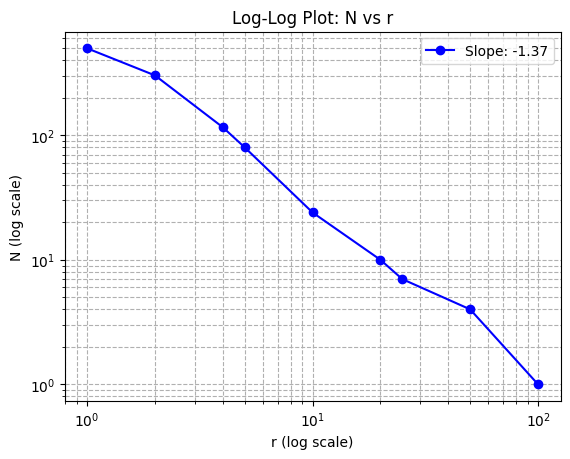

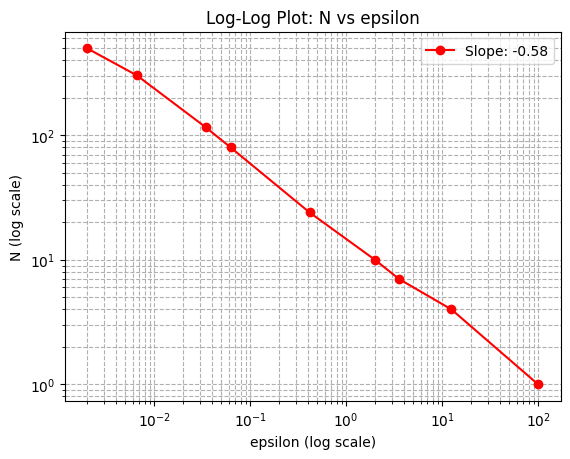

(np.float64(-1.3725459031440896), np.float64(-0.5796762299559679))

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Data: (r, epsilon, N)

# Extracting the columns into individual arrays
r = np.array([x[0] for x in res])
epsilon = np.array([x[1] for x in res])
N = np.array([x[2] for x in res])

def plot_with_slope(x, y, xlabel, ylabel, title, color='b'):
    # Perform log-log regression to calculate slope
    slope, intercept = np.polyfit(np.log10(x), np.log10(y), 1)
    
    # Plot the data
    fig, ax = plt.subplots()
    ax.loglog(x, y, marker='o', linestyle='-', color=color, label=f'Slope: {slope:.2f}')
    ax.set_xlabel(f'{xlabel} (log scale)')
    ax.set_ylabel(f'{ylabel} (log scale)')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, which="both", ls="--")
    return fig, slope

# Create both plots with slopes
fig1, slope1 = plot_with_slope(r, N, 'r', 'N', 'Log-Log Plot: N vs r', 'b')
fig2, slope2 = plot_with_slope(epsilon, N, 'epsilon', 'N', 'Log-Log Plot: N vs epsilon', 'r')

# Display plots
plt.show()

# Print slopes for reference
slope1, slope2